# Clarify AI - 信贷评分模型可解释性演示

这个notebook演示了如何使用Clarify AI来解释信贷评分模型的决策过程。

## 目标
- 创建一个模拟的信贷数据集
- 训练一个随机森林分类器
- 使用SHAP进行模型解释
- 生成业务友好的解释报告

## 1. 导入必要的库

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 设置字体支持
try:
    # plt.rcParams['font.sans-serif'] = ['Arial']  # 使用通用字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 黑体、微软雅黑
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
except:
    pass

# 导入我们的解释器
from clarify_ai import ModelExplainer

print("✅ 所有库导入成功！")

已设置中文字体: Arial Unicode MS
✅ 所有库导入成功！


## 2. 创建模拟信贷数据集

我们将创建一个包含10个特征的模拟信贷数据集，这些特征模拟了真实的信贷申请场景。

In [2]:
def create_credit_dataset(n_samples=1000):
    """创建模拟的信贷数据集"""
    X, y = make_classification(
        n_samples=n_samples, 
        n_features=10, 
        n_informative=5, 
        n_redundant=2,
        random_state=42
    )
    
    # 创建有意义的特征名称
    feature_names = [
        '月收入', '年龄', '工作年限', 
        '负债比例', '信用记录长度', 
        '历史逾期次数', '贷款金额', 
        '房产价值', '教育水平', '婚姻状态'
    ]
    
    # 转换为DataFrame
    X_df = pd.DataFrame(X, columns=feature_names)
    
    # 调整数据范围使其更符合实际
    X_df['月收入'] = X_df['月收入'] * 5000 + 8000  # 3000-13000
    X_df['年龄'] = X_df['年龄'] * 20 + 25  # 20-45岁
    X_df['工作年限'] = X_df['工作年限'] * 8 + 1  # 1-9年
    X_df['负债比例'] = X_df['负债比例'] * 0.4 + 0.2  # 20%-60%
    X_df['信用记录长度'] = X_df['信用记录长度'] * 5 + 1  # 1-6年
    X_df['历史逾期次数'] = np.round(X_df['历史逾期次数'] * 3)  # 0-3次
    X_df['贷款金额'] = X_df['贷款金额'] * 200000 + 100000  # 10-30万
    X_df['房产价值'] = X_df['房产价值'] * 1000000 + 500000  # 50-150万
    X_df['教育水平'] = np.round(X_df['教育水平'] * 3 + 1)  # 1-4 (高中、大专、本科、研究生)
    X_df['婚姻状态'] = np.round(X_df['婚姻状态'])  # 0-1 (未婚、已婚)
    
    return X_df, y

# 创建数据集
X, y = create_credit_dataset()

print(f"✅ 数据集创建成功！")
print(f"数据集形状: {X.shape}")
print(f"目标变量分布: {np.bincount(y)}")
print(f"\n前5行数据:")
X.head()

✅ 数据集创建成功！
数据集形状: (1000, 10)
目标变量分布: [497 503]

前5行数据:


,月收入,年龄,工作年限,负债比例,信用记录长度,历史逾期次数,贷款金额,房产价值,教育水平,婚姻状态
0,13625.501940,48.562477,4.948128,0.516352,-2.071389,4.0,383903.017810,1.857325e+06,4.0,-2.0
1,5176.795722,97.772582,-11.179318,-0.416682,9.083486,14.0,738058.438991,-3.902544e+05,5.0,-4.0
2,10581.564256,68.308527,-4.027886,0.045231,3.462589,4.0,366580.914293,-1.458175e+06,-0.0,-2.0
3,10686.408638,44.332356,0.076638,0.468302,-3.792579,3.0,201637.125911,-5.344714e+05,-4.0,-2.0
4,9391.922538,46.316559,-12.799335,-0.694267,4.575537,2.0,-34823.770317,1.098330e+06,-1.0,1.0


## 3. 数据集基本统计信息

In [3]:
# 查看数据集的基本统计信息
print("📊 数据集基本统计信息:")
X.describe()

📊 数据集基本统计信息:


,月收入,年龄,工作年限,负债比例,信用记录长度,历史逾期次数,贷款金额,房产价值,教育水平,婚姻状态
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.00000,1000.000000
mean,10402.358953,24.779303,0.420993,0.003021,3.345293,1.491000,1.911701e+05,5.171149e+05,0.82500,0.613000
std,7919.043906,32.370963,8.193566,0.607573,7.448884,4.875417,4.000324e+05,1.029048e+06,3.16803,2.829706
min,-15305.838024,-91.284066,-23.249551,-1.503214,-18.446421,-13.000000,-1.359613e+06,-2.754479e+06,-10.00000,-8.000000
25%,5288.922830,2.355755,-5.236254,-0.401633,-2.049777,-2.000000,-5.521973e+04,-1.766480e+05,-1.00000,-1.000000
50%,10916.805416,25.594936,0.664871,-0.104372,3.707805,1.000000,2.106446e+05,5.257716e+05,1.00000,1.000000
75%,15608.279460,46.544113,6.155551,0.292114,8.239377,5.000000,4.515878e+05,1.179153e+06,3.00000,2.000000
max,33330.306402,117.113373,27.211195,2.474277,31.183964,17.000000,1.591394e+06,3.589890e+06,10.00000,8.000000


## 4. 特征描述字典

为了生成更好的业务解释，我们定义每个特征的业务含义。

In [4]:
# 特征描述字典
feature_descriptions = {
    '月收入': '申请人月收入(元)',
    '年龄': '申请人年龄(岁)',
    '工作年限': '当前工作持续时间(年)',
    '负债比例': '月还款总额/月收入',
    '信用记录长度': '信用历史长度(年)',
    '历史逾期次数': '过去12个月内的逾期次数',
    '贷款金额': '申请贷款金额(元)',
    '房产价值': '申请人房产估值(元)',
    '教育水平': '教育程度(1-高中,2-大专,3-本科,4-研究生)',
    '婚姻状态': '婚姻状况(0-未婚,1-已婚)'
}

print("✅ 特征描述定义完成！")
for feature, desc in feature_descriptions.items():
    print(f"  {feature}: {desc}")

✅ 特征描述定义完成！
  月收入: 申请人月收入(元)
  年龄: 申请人年龄(岁)
  工作年限: 当前工作持续时间(年)
  负债比例: 月还款总额/月收入
  信用记录长度: 信用历史长度(年)
  历史逾期次数: 过去12个月内的逾期次数
  贷款金额: 申请贷款金额(元)
  房产价值: 申请人房产估值(元)
  教育水平: 教育程度(1-高中,2-大专,3-本科,4-研究生)
  婚姻状态: 婚姻状况(0-未婚,1-已婚)


## 5. 数据集划分

In [5]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ 数据集划分完成！")
print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")
print(f"训练集目标分布: {np.bincount(y_train)}")
print(f"测试集目标分布: {np.bincount(y_test)}")

✅ 数据集划分完成！
训练集大小: (800, 10)
测试集大小: (200, 10)
训练集目标分布: [385 415]
测试集目标分布: [112  88]


## 6. 模型训练

In [6]:
# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 评估模型性能
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"✅ 模型训练完成！")
print(f"训练集准确率: {train_score:.3f}")
print(f"测试集准确率: {test_score:.3f}")

# 查看模型的特征重要性
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 模型内置特征重要性:")
feature_importance

✅ 模型训练完成！
训练集准确率: 1.000
测试集准确率: 0.955

📊 模型内置特征重要性:


,feature,importance
4,信用记录长度,0.219306
0,月收入,0.168160
9,婚姻状态,0.137223
5,历史逾期次数,0.127277
3,负债比例,0.127027
6,贷款金额,0.076695
1,年龄,0.069874
7,房产价值,0.026560
2,工作年限,0.025305
8,教育水平,0.022573


## 7. 初始化Clarify AI解释器

In [7]:
# 初始化解释器
explainer = ModelExplainer(
    model=model,
    X_train=X_train,
    feature_descriptions=feature_descriptions,
    output_dir="reports/credit_scoring"
)

print("✅ Clarify AI解释器初始化成功！")
print(f"解释器类型: {explainer.shap_explainer.explainer_type}")

✅ Clarify AI解释器初始化成功！
解释器类型: tree


## 8. 全局特征重要性分析

使用SHAP计算全局特征重要性，这比模型内置的特征重要性更准确。

🌍 SHAP全局特征重要性:
信用记录长度: 0.1540
历史逾期次数: 0.0954
月收入: 0.0816
婚姻状态: 0.0755
负债比例: 0.0610
贷款金额: 0.0282
年龄: 0.0246
教育水平: 0.0058
工作年限: 0.0050
房产价值: 0.0048


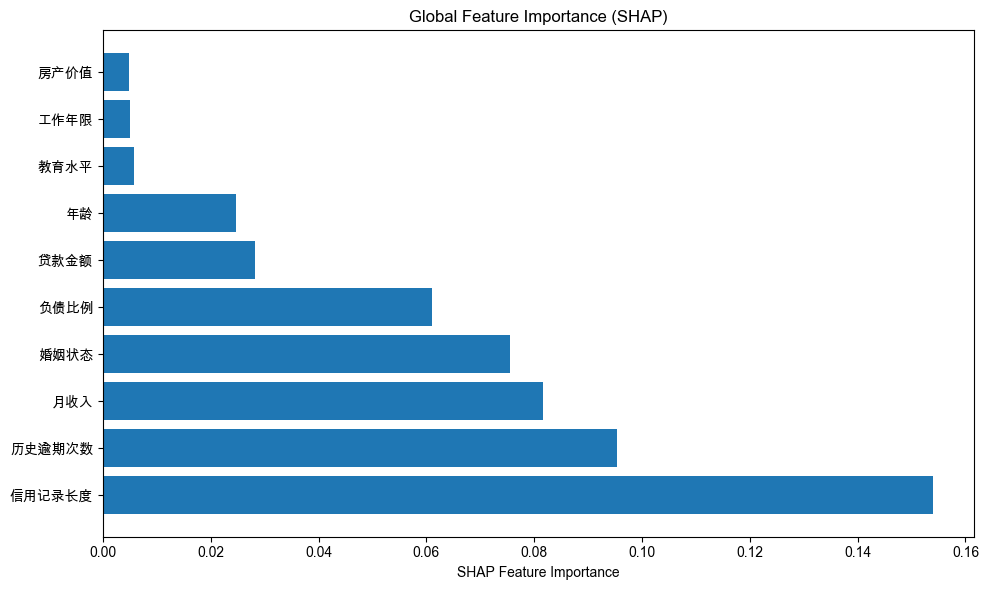

In [8]:
# 获取全局特征重要性
global_importance = explainer.get_global_importance(X_test)

print("🌍 SHAP全局特征重要性:")
for feature, score in global_importance.items():
    print(f"{feature}: {score:.4f}")

# 可视化全局特征重要性
plt.figure(figsize=(10, 6))
features = list(global_importance.keys())
scores = list(global_importance.values())

plt.barh(range(len(features)), scores)
plt.yticks(range(len(features)), features)
plt.xlabel('SHAP Feature Importance')
plt.title('Global Feature Importance (SHAP)')
plt.tight_layout()
plt.show()

## 9. 局部解释 - 单个预测分析

选择几个测试样本，分析模型对它们的预测决策过程。

In [9]:
# 选择要分析的样本
sample_indices = [0]
contributions = None

for idx in sample_indices:
    print(f"\n{'='*50}")
    print(f"📋 样本 #{idx} 分析")
    print(f"{'='*50}")
    
    # 获取样本信息
    sample = X_test.iloc[idx]
    actual_label = y_test[idx]
    predicted_label = model.predict([sample])[0]
    predicted_proba = model.predict_proba([sample])[0]
    
    print(f"实际标签: {actual_label}")
    print(f"预测标签: {predicted_label}")
    print(f"预测概率: {predicted_proba}")

    print(sample)
    # 显示样本特征值
    print(f"\n📊 样本特征值:")
    for feature, value in sample.items():
        desc = feature_descriptions.get(feature, feature)
        print(f"  {desc}: {value:.2f}")
    
    # 获取局部解释
    local_explanation = explainer.explain_prediction(idx, X_test)
    
    print(f"\n🔍 SHAP特征贡献度:")
    contributions = local_explanation['feature_contributions']
    sorted_contributions = sorted(contributions.items(), key=lambda x: abs(x[1]), reverse=True)
    
    for feature, contrib in sorted_contributions:
        desc = feature_descriptions.get(feature, feature)
        # 取第一个值来判断方向和显示
        direction = "正向" if contrib > 0 else "负向"
        print(f"  {desc}: {contrib:.4f} ({direction})")


📋 样本 #0 分析
实际标签: 0
预测标签: 0
预测概率: [0.97 0.03]
月收入        10689.083010
年龄            85.894763
工作年限          -5.955462
负债比例           0.042451
信用记录长度         7.938935
历史逾期次数         8.000000
贷款金额      678186.709835
房产价值      898564.065892
教育水平           6.000000
婚姻状态          -3.000000
Name: 521, dtype: float64

📊 样本特征值:
  申请人月收入(元): 10689.08
  申请人年龄(岁): 85.89
  当前工作持续时间(年): -5.96
  月还款总额/月收入: 0.04
  信用历史长度(年): 7.94
  过去12个月内的逾期次数: 8.00
  申请贷款金额(元): 678186.71
  申请人房产估值(元): 898564.07
  教育程度(1-高中,2-大专,3-本科,4-研究生): 6.00
  婚姻状况(0-未婚,1-已婚): -3.00

🔍 SHAP特征贡献度:
  信用历史长度(年): 0.2022 (正向)
  过去12个月内的逾期次数: 0.1285 (正向)
  月还款总额/月收入: 0.0693 (正向)
  申请贷款金额(元): 0.0551 (正向)
  婚姻状况(0-未婚,1-已婚): 0.0492 (正向)
  申请人年龄(岁): -0.0360 (负向)
  申请人月收入(元): 0.0278 (正向)
  当前工作持续时间(年): -0.0108 (负向)
  教育程度(1-高中,2-大专,3-本科,4-研究生): 0.0044 (正向)
  申请人房产估值(元): -0.0006 (负向)


## 10. 自然语言解释

将技术性的SHAP结果转化为业务友好的自然语言描述。

In [10]:
# 生成全局解释的自然语言描述
nl_global = explainer.nl_explainer.explain_global_importance(
    global_importance, feature_descriptions
)

print("🌍 全局特征重要性的自然语言解释:")
print(nl_global)

# 为第一个样本生成局部解释的自然语言描述
local_explanation = explainer.explain_prediction(0, X_test)
nl_local = explainer.nl_explainer.explain_local_prediction(
    local_explanation, feature_descriptions
)

print(f"\n🎯 样本 #0 的自然语言解释:")
print(nl_local)

🌍 全局特征重要性的自然语言解释:
根据模型分析，影响预测结果的关键因素按重要性排序如下：

1. **信用历史长度(年)** (重要性: 0.154)
   - 影响程度: 决定性
   - 该因素对模型决策起决定性作用，是最关键的判断依据

2. **过去12个月内的逾期次数** (重要性: 0.095)
   - 影响程度: 重要
   - 该因素对模型决策有重要影响，需要重点关注

3. **申请人月收入(元)** (重要性: 0.082)
   - 影响程度: 重要
   - 该因素对模型决策有重要影响，需要重点关注

4. **婚姻状况(0-未婚,1-已婚)** (重要性: 0.075)
   - 影响程度: 重要
   - 该因素对模型决策有重要影响，需要重点关注

5. **月还款总额/月收入** (重要性: 0.061)
   - 影响程度: 重要
   - 该因素对模型决策有重要影响，需要重点关注



🎯 样本 #0 的自然语言解释:
**预测结果: 拒绝/低风险** (预测值: 0.030)

**决策原因: 负向贡献因素占主导**

**正向影响因素 (支持通过):**
• 信用历史长度(年): 7.938934736566366 (贡献度: +0.202)
• 过去12个月内的逾期次数: 8.0 (贡献度: +0.128)
• 月还款总额/月收入: 0.04245064608843685 (贡献度: +0.069)

**负向影响因素 (支持拒绝):**
• 申请人年龄(岁): 85.8947631203541 (贡献度: -0.036)
• 当前工作持续时间(年): -5.955461984294912 (贡献度: -0.011)
• 申请人房产估值(元): 898564.0658920073 (贡献度: -0.001)




## 11. 业务建议生成

In [11]:
# 生成业务建议
local_explanations = [explainer.explain_prediction(i, X_test) for i in [0, 5, 10]]
business_recommendations = explainer.nl_explainer.generate_business_recommendations(
    global_importance, local_explanations
)

print("💡 业务建议:")
print(business_recommendations)

💡 业务建议:
## 业务优化建议

### 1. 重点关注 '信用记录长度'
该特征是模型决策的最重要因素，建议:
- 确保该特征数据的准确性和完整性
- 建立该特征的监控机制
- 针对该特征制定相应的业务策略

### 2. 个案处理建议
- 在分析的 3 个样本中，有 1 个被预测为高风险
- 建议对高风险样本进行人工复核
- 关注负向贡献因素，制定针对性改进措施

### 3. 模型监控建议
- 定期评估模型性能，确保预测准确性
- 监控特征分布变化，及时发现数据漂移
- 建立模型解释结果的业务验证机制



In [12]:
# # 为第一个样本生成局部解释的自然语言描述
# local_explanation = explainer.explain_prediction(0, X_test)

# # 生成全局解释的自然语言描述
# result = explainer.get_natural_language_explanation(global_importance, local_explanation, X_test)
# nl_global, nl_local, nl_recommendations = result['global'], result['local'], result['recommendations']

# print("🌍 全局特征重要性的自然语言解释:")
# print(nl_global)

# print(f"\n🎯 样本 #0 的自然语言解释:")
# print(nl_local)

# print("💡 业务建议:")
# print(nl_recommendations)


## 12. 生成完整的HTML报告

将所有分析结果整合成一个专业的HTML报告。

In [13]:
# 生成完整报告
report_path = explainer.generate_report(
    X_test=X_test,
    instances_to_explain=[0, 5, 10],  # 解释前3个测试样本
    model_type="随机森林分类器 (信贷评分)",
    report_name="credit_scoring_explanation"
)

print(f"✅ 报告生成成功！")
print(f"报告路径: {report_path}")
print(f"\n你可以在浏览器中打开这个HTML文件查看完整的可解释性报告。")

创建waterfall图时出错: only length-1 arrays can be converted to Python scalars
创建waterfall图时出错: only length-1 arrays can be converted to Python scalars
创建waterfall图时出错: only length-1 arrays can be converted to Python scalars
✅ 报告生成成功！
报告路径: reports/credit_scoring/credit_scoring_explanation.html

你可以在浏览器中打开这个HTML文件查看完整的可解释性报告。


Traceback (most recent call last):
  File "/Users/jiahaoluo/Desktop/SHOW-ME-THE-CODE/clarify-ai/src/core/shap_explainer.py", line 264, in create_waterfall_plot
    base_value = float(self.explainer.expected_value)
TypeError: only length-1 arrays can be converted to Python scalars
Traceback (most recent call last):
  File "/Users/jiahaoluo/Desktop/SHOW-ME-THE-CODE/clarify-ai/src/core/shap_explainer.py", line 264, in create_waterfall_plot
    base_value = float(self.explainer.expected_value)
TypeError: only length-1 arrays can be converted to Python scalars
Traceback (most recent call last):
  File "/Users/jiahaoluo/Desktop/SHOW-ME-THE-CODE/clarify-ai/src/core/shap_explainer.py", line 264, in create_waterfall_plot
    base_value = float(self.explainer.expected_value)
TypeError: only length-1 arrays can be converted to Python scalars


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

## 13. 模型性能总结

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 预测测试集
y_pred = model.predict(X_test)

print("📈 模型性能总结:")
print(f"测试集准确率: {test_score:.3f}")
print(f"\n分类报告:")
print(classification_report(y_test, y_pred))

print(f"\n混淆矩阵:")
print(confusion_matrix(y_test, y_pred))

# 可视化混淆矩阵
import seaborn as sns
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 14. 总结

通过这个演示，我们展示了Clarify AI的核心功能：

1. **数据准备**: 创建了一个模拟的信贷评分数据集
2. **模型训练**: 使用随机森林训练了一个分类器
3. **全局解释**: 使用SHAP分析了整体特征重要性
4. **局部解释**: 分析了单个预测的决策过程
5. **自然语言解释**: 将技术结果转化为业务友好的描述
6. **报告生成**: 创建了专业的HTML解释报告

### 主要优势:
- **业务友好**: 非技术人员也能理解模型决策
- **全面解释**: 从全局到局部的多层次分析
- **可视化报告**: 直观的图表和解释
- **易于集成**: 简单的API，支持各种ML模型

### 应用场景:
- 金融风控模型解释
- 医疗诊断AI解释
- 客户行为预测解释
- 监管合规要求

In [20]:
instance_idx = 0
# explainer.shap_explainer.create_waterfall_plot(instance_idx, X_test, local_chart_path)

In [24]:
instance_shap = explainer.shap_explainer.shap_values[instance_idx, :, 0]
instance_shap = np.array(instance_shap).flatten()
instance_shap

array([ 0.027823  , -0.03598526, -0.01079902,  0.06927112,  0.20222127,
        0.12846251,  0.05513558, -0.00056125,  0.00441145,  0.04918308])

In [27]:
len(instance_shap)

10

In [26]:
len(explainer.shap_explainer.feature_names)

10